In [1]:
import os
import glob
import json
from itertools import product
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import mplhep as hep
plt.style.use(hep.style.ATLAS)
plt.rc('legend',fontsize='large')
plt.rc('axes',labelsize='x-large')
plt.rc('text',usetex='false')
plt.rc('xtick', labelsize='large')
import seaborn as sns
import joblib
from packages.constants import HOME_PATH, STEP_PREFIX
from packages.utils import get_electron_label, get_jet_label
%matplotlib inline

### Functions

In [184]:
SHOWER_SHAPES = {
    'reta': {
        'label': '$R_{eta}$',
        'range': (0,1),
        'electron_range': (0.82, 1),
        'jet_range': (0.6,1),
        'step': 'L2Calo'
    },
    'eratio': {
        'label': '$E_{ratio}$',
        'range': (0,1),
        'electron_range': (0.9, 1),
        'jet_range': (0,1),
        'step': 'L2Calo'
    },
    'f1': {
        'label': '$f_1$',
        'range': (0,1),
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    },
    'ehad1': {
        'label': '$E_{had1}$',
        'range': None,
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    },
    'f3': {
        'label': '$f_3$',
        'range': (0,1),
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    },
    'weta2': {
        'label': '$\omega_{\eta 2}$',
        'range': None,
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    },
    'wstot': {
        'label': '$\omega_{stot}$',
        'range': None,
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    },
    'e2tsts1': {
        'label': 'e2tsts1',
        'range': None,
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    }
}
HIST_DF_COLS = ['bin_start', 'bin_end', 'hist']

In [129]:
def save_hists_df(hists_dict, output_dir, plot_ss, name):
    for hist_name, org_hist_df in hists_dict.items():
        source_name = hist_name.replace(' ', '_').lower()
        filepath = os.path.join(output_dir, f'{plot_ss}_{source_name}_{name}_hist.csv')
        org_hist_df.to_csv(filepath)
    return 0

In [172]:
def get_hist_area(hist_df):
    return (hist_df['hist'] * (hist_df['bin_end'] - hist_df['bin_start'])).sum()

def normalize_hist(hist_df):
    hist_df = hist_df.copy()
    area = get_hist_area(hist_df)
    hist_df['hist'] = hist_df['hist']/area
    return hist_df

def subsample_hist_df(hist_df, subsample, normalize=False):
    subsampled_hist_df = hist_df.reset_index()
    subsampled_hist_df['group'] = subsampled_hist_df['index'] // subsample
    agg_dict = dict(hist='sum', bin_start='min', bin_end='max')
    subsampled_hist_df = subsampled_hist_df.groupby('group') \
        .agg(agg_dict).dropna().reset_index(drop=True)
    if normalize:
        subsampled_hist_df = normalize_hist(subsampled_hist_df)
    return subsampled_hist_df

## Distribution plots

### Loading data

In [13]:
plot_cols = list()
step='L2Calo'
basepath = os.path.join('..', '..')
output_dir = os.path.join(basepath, 'analysis', 'shower_shapes_distributions')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
datapath = os.path.join(basepath, 'data')
collision_path = os.path.join(datapath, 'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet')
#                              'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet_et4_eta4.parquet')
boosted_path = os.path.join(datapath, 'ided_mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2.parquet')

shower_shapes = [STEP_PREFIX[step] + ss for ss in SHOWER_SHAPES.keys()]
shower_shapes

['trig_L2_cl_reta',
 'trig_L2_cl_eratio',
 'trig_L2_cl_f1',
 'trig_L2_cl_ehad1',
 'trig_L2_cl_f3',
 'trig_L2_cl_weta2',
 'trig_L2_cl_wstot',
 'trig_L2_cl_e2tsts1']

In [6]:
boosted_data = pd.read_parquet(boosted_path, columns=shower_shapes)
boosted_data.head()

,trig_L2_cl_reta,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_ehad1,trig_L2_cl_f3,trig_L2_cl_weta2,trig_L2_cl_wstot,trig_L2_cl_e2tsts1
0,0.925877,0.982229,0.286768,1626.380493,0.004404,0.010177,1.134755,24.469589
1,0.988089,0.816197,0.085186,-184.739105,0.008879,0.009084,1.250962,59.001091
2,0.935216,0.890477,0.466089,-161.464890,-0.000920,0.011774,2.881309,198.510132
3,0.962935,0.948033,0.320025,-130.190170,0.001840,0.009567,1.323367,67.998497
4,0.670090,0.138930,0.270767,5028.686035,0.011920,0.017711,6.128632,846.002319


In [10]:
start_time = datetime.now()
print(f'Start: {start_time}')
add_cols = ['target', 'el_lhmedium', 'el_lhvloose']
collision_data = pd.read_parquet(collision_path, columns=shower_shapes + add_cols)
read_time = datetime.now()
print(f'Time to read data {read_time-start_time}')
print(collision_data.shape)
jet_label = get_jet_label(collision_data, 'el_lhvloose')
collision_data['jet'] = jet_label
print(f'There are {jet_label.sum()} jets')
jet_time = datetime.now()
print(f'Time to jets {jet_time-read_time}')
electron_label = get_electron_label(collision_data, 'el_lhmedium')
collision_data['electron'] = electron_label
print(f'There are {electron_label.sum()} electrons')
el_time = datetime.now()
print(f'Time to electrons {el_time-jet_time}')
collision_data.drop(add_cols, axis=1, inplace=True)
collision_data.head()
end_time = datetime.now()
print(f'Time to drop {end_time-el_time}')

Start: 2022-09-20 13:49:52.360533
Time to read data 0:00:40.848382
(43311283, 11)
There are 10906928 jets
Time to jets 0:00:00.200709
There are 28955057 electrons
Time to electrons 0:00:00.139145
Time to drop 0:00:01.752660


### $E_{ratio}$

This shower shape is a ratio. The numerator is the difference between the biggest and the second biggest energy deposits on EM1 inside the cluster. The denominator is the sum of these energies. This way the shower shape should be limited to the [0,1] interval. However, there were values bigger than 1, which were considered problematic samples and removed from plots.

In [47]:
hists = dict()
plot_ss = 'eratio'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss

# boosted_range = ss_info['range']
boosted_range = None
# boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_bins = 1000
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=boosted_bins, range=boosted_range)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)

# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_range = boosted_range
el_time = datetime.now()
print(f'Start electron time {el_time}')
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, range=el_range)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)

jet_time = datetime.now()
print(f'Electron hist time {jet_time-el_time}')
jet_bins = el_bins
jet_range = el_range
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, range=jet_range)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)
end_time = datetime.now()
print(f'Jet hist time {jet_time-el_time}')

Start electron time 2022-09-20 14:44:34.847781
Electron hist time 0:00:02.416552
Jet hist time 0:00:02.416552


/tmp/ipykernel_1023/3681358082.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


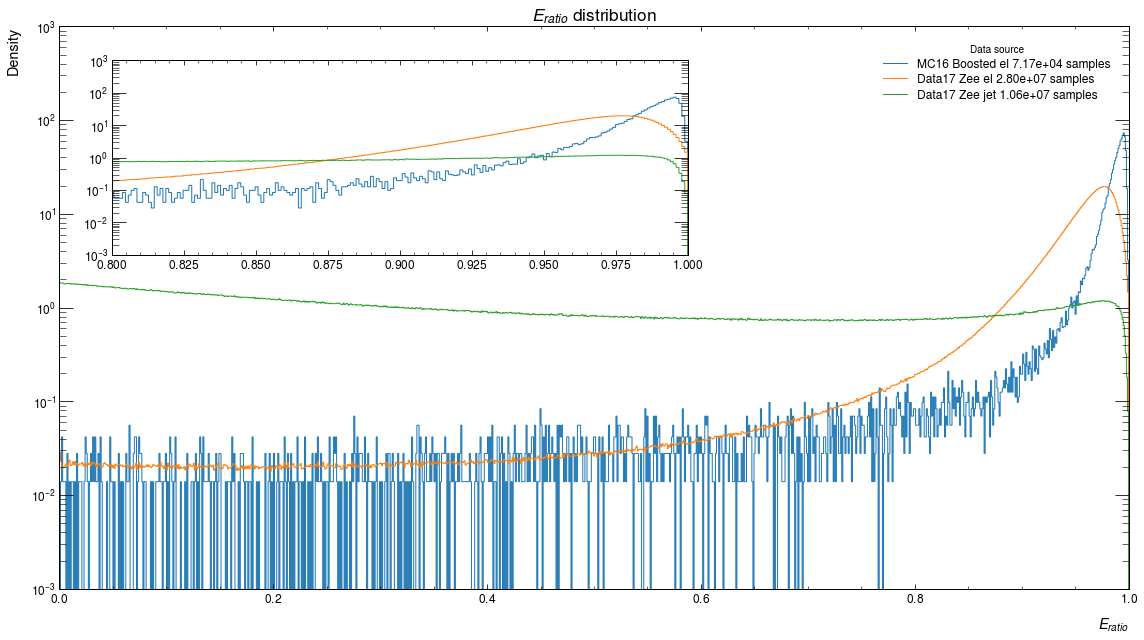

In [44]:
sub_ax_pos = [0.1, 0.6, 0.5, 0.3]
fig, ax = plt.subplots(1,1, figsize=(16,9), dpi=72)
plot_scale = 'log'
sub_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, org_hist_df in hists.items():
    n_samples = '{:.2e}'.format(int(org_hist_df['hist'].sum()))
    hist_df = normalize_hist(org_hist_df)
    label = f'{hist_name} {n_samples} samples'
    bins = np.append(hist_df['bin_start'].values, hist_df['bin_end'].iloc[-1])
    ax.stairs(hist_df['hist'],bins, label=label)
    sub_ax.stairs(hist_df['hist'],bins, label=label)

sub_ax.set_xlim(0.8,1)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_yscale(plot_scale)
sub_ax.set_yscale(plot_scale)
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{plot_ss}_limited_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

In [56]:
save_hists_df(hists, output_dir, plot_ss)

0

### $R_{\eta}$
This shower shape is a ratio between Energy in 3x7 region by 7x7 region (The regions are $\eta$ x $\phi$). This way the shower shape should be limited to the [0,1] interval. However there were values bigger than 1.

In [57]:
hists = dict()
plot_ss = 'reta'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss

# boosted_range = ss_info['range']
boosted_range = None
# boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_bins = 1000
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=boosted_bins, range=boosted_range)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)

# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_range = boosted_range
el_time = datetime.now()
print(f'Start electron time {el_time}')
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, range=el_range)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)

jet_time = datetime.now()
print(f'Electron hist time {jet_time-el_time}')
jet_bins = el_bins
jet_range = el_range
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, range=jet_range)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)
end_time = datetime.now()
print(f'Jet hist time {jet_time-el_time}')

Start electron time 2022-09-20 14:55:52.771112
Electron hist time 0:00:03.023899
Jet hist time 0:00:03.023899


/tmp/ipykernel_1023/880452004.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


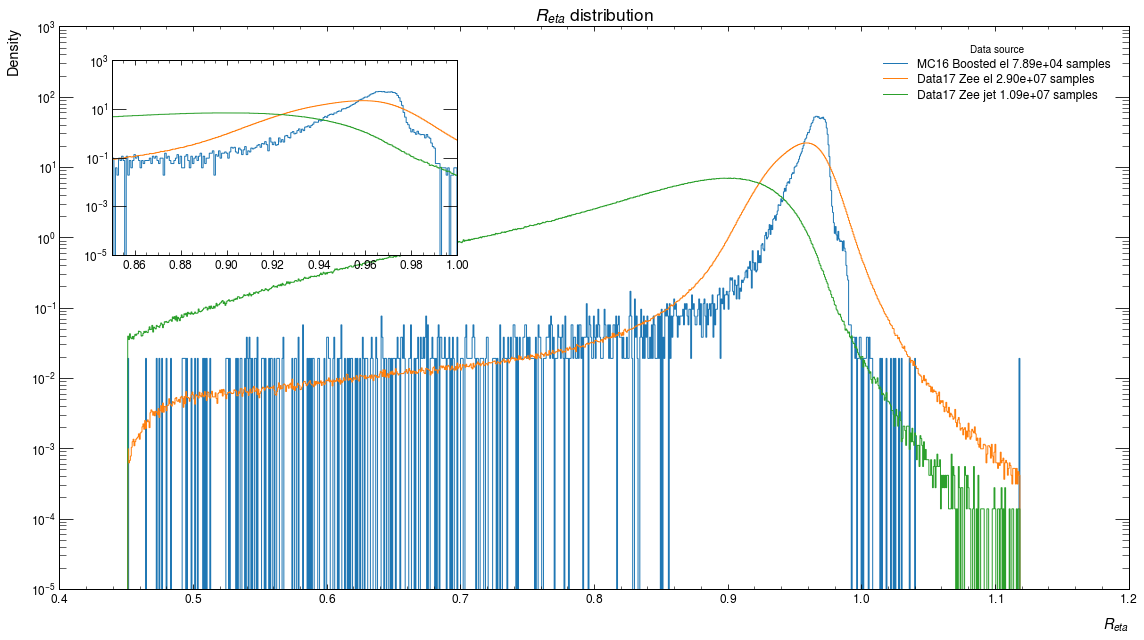

In [61]:
sub_ax_pos = [0.1, 0.6, 0.3, 0.3]
fig, ax = plt.subplots(1,1, figsize=(16,9), dpi=72)
plot_scale = 'log'
sub_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, org_hist_df in hists.items():
    n_samples = '{:.2e}'.format(int(org_hist_df['hist'].sum()))
    hist_df = normalize_hist(org_hist_df)
    label = f'{hist_name} {n_samples} samples'
    bins = np.append(hist_df['bin_start'].values, hist_df['bin_end'].iloc[-1])
    ax.stairs(hist_df['hist'],bins, label=label)
    sub_ax.stairs(hist_df['hist'],bins, label=label)

sub_ax.set_xlim(0.85,1)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_yscale(plot_scale)
sub_ax.set_yscale(plot_scale)
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{plot_ss}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

In [62]:
save_hists_df(hists, output_dir, plot_ss)

0

### $E_{had1}$
No documentation

In [63]:
hists = dict()
plot_ss = 'ehad1'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss

# boosted_range = ss_info['range']
boosted_range = None
# boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_bins = 1000
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=boosted_bins, range=boosted_range)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)

# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_range = boosted_range
el_time = datetime.now()
print(f'Start electron time {el_time}')
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, range=el_range)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)

jet_time = datetime.now()
print(f'Electron hist time {jet_time-el_time}')
jet_bins = el_bins
jet_range = el_range
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, range=jet_range)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)
end_time = datetime.now()
print(f'Jet hist time {jet_time-el_time}')

Start electron time 2022-09-20 15:03:00.470595
Electron hist time 0:00:03.275180
Jet hist time 0:00:03.275180


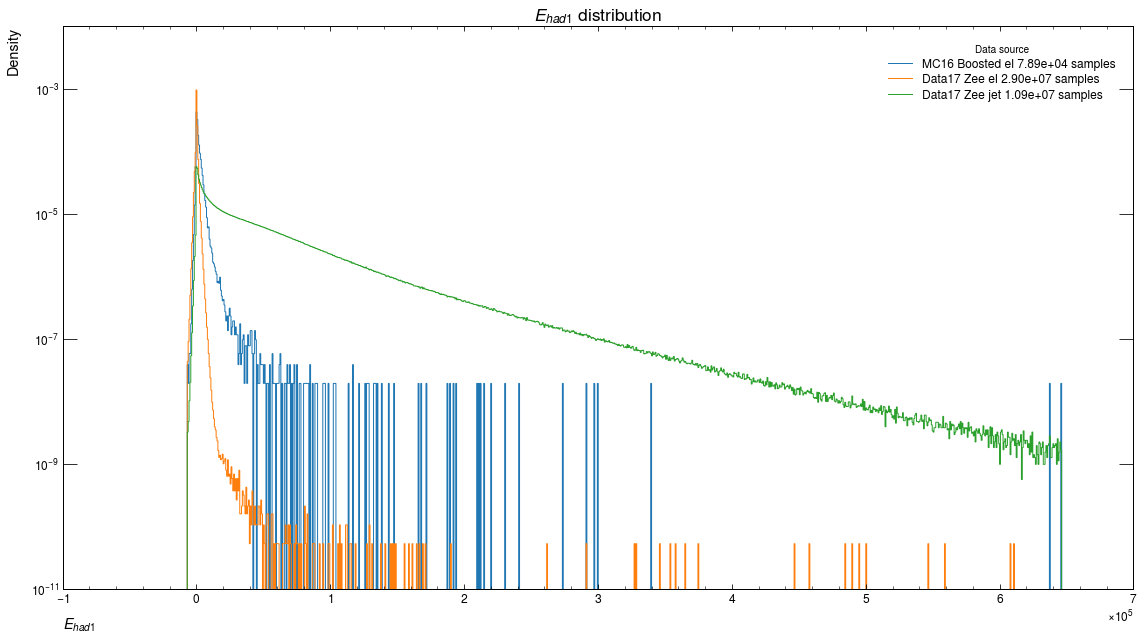

In [66]:
# sub_ax_pos = [0.1, 0.6, 0.3, 0.3]
fig, ax = plt.subplots(1,1, figsize=(16,9), dpi=72)
plot_scale = 'log'
# sub_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, org_hist_df in hists.items():
    n_samples = '{:.2e}'.format(int(org_hist_df['hist'].sum()))
    hist_df = normalize_hist(org_hist_df)
    label = f'{hist_name} {n_samples} samples'
    bins = np.append(hist_df['bin_start'].values, hist_df['bin_end'].iloc[-1])
    ax.stairs(hist_df['hist'],bins, label=label)
    # sub_ax.stairs(hist_df['hist'],bins, label=label)

# sub_ax.set_xlim(0.85,1)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'], loc='left')
ax.legend(title='Data source')
ax.set_yscale(plot_scale)
# sub_ax.set_yscale(plot_scale)
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{plot_ss}_limited_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

In [67]:
save_hists_df(hists, output_dir, plot_ss)

0

### $f_1$

This shower shape is a ratio between the energy deposited in EM1 over the total energy in the EM layers. This way the shower shape should be limited to the [0,1] interval. All values were in that interval.

In [84]:
hists = dict()
plot_ss = 'f1'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss
# boosted_range = ss_info['range']
boosted_range = None
# boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_bins = 1000
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=boosted_bins, range=boosted_range)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)
# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_range = boosted_range
el_time = datetime.now()
print(f'Start electron time {el_time}')
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, range=el_range)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)
jet_time = datetime.now()
print(f'Electron hist time {jet_time-el_time}')
jet_bins = el_bins
jet_range = el_range
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, range=jet_range)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)
end_time = datetime.now()
print(f'Jet hist time {jet_time-el_time}')

Start electron time 2022-09-20 15:23:59.670629
Electron hist time 0:00:02.430678
Jet hist time 0:00:02.430678


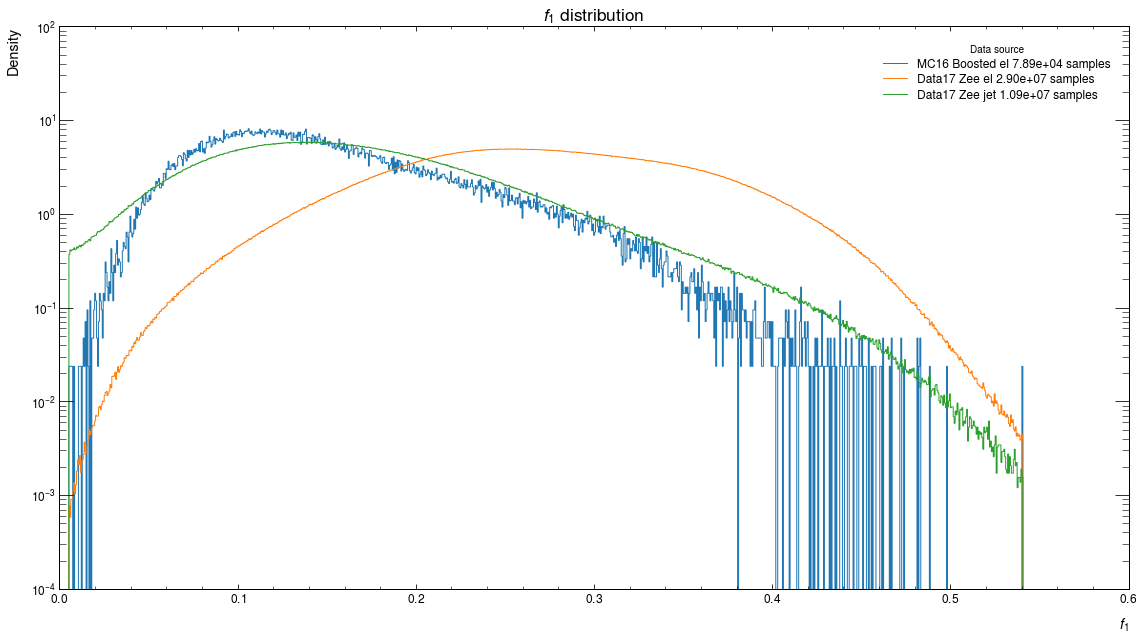

In [85]:
# sub_ax_pos = [0.1, 0.6, 0.3, 0.3]
fig, ax = plt.subplots(1,1, figsize=(16,9), dpi=72)
plot_scale = 'log'
# sub_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, org_hist_df in hists.items():
    n_samples = '{:.2e}'.format(int(org_hist_df['hist'].sum()))
    hist_df = normalize_hist(org_hist_df)
    label = f'{hist_name} {n_samples} samples'
    bins = np.append(hist_df['bin_start'].values, hist_df['bin_end'].iloc[-1])
    ax.stairs(hist_df['hist'],bins, label=label)
    # sub_ax.stairs(hist_df['hist'],bins, label=label)
# sub_ax.set_xlim(0.85,1)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_yscale(plot_scale)
# sub_ax.set_yscale(plot_scale)
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{plot_ss}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

In [73]:
save_hists_df(hists, output_dir, plot_ss)

0

### $f_3$

In [86]:
hists = dict()
plot_ss = 'f3'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss
# boosted_range = ss_info['range']
boosted_range = None
# boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_bins = 1000
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=boosted_bins, range=boosted_range)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)
# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_range = boosted_range
el_time = datetime.now()
print(f'Start electron time {el_time}')
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, range=el_range)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)
jet_time = datetime.now()
print(f'Electron hist time {jet_time-el_time}')
jet_bins = el_bins
jet_range = el_range
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, range=jet_range)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)
end_time = datetime.now()
print(f'Jet hist time {jet_time-el_time}')

Start electron time 2022-09-20 15:24:32.413846
Electron hist time 0:00:02.401086
Jet hist time 0:00:02.401086


/tmp/ipykernel_1023/3456229112.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


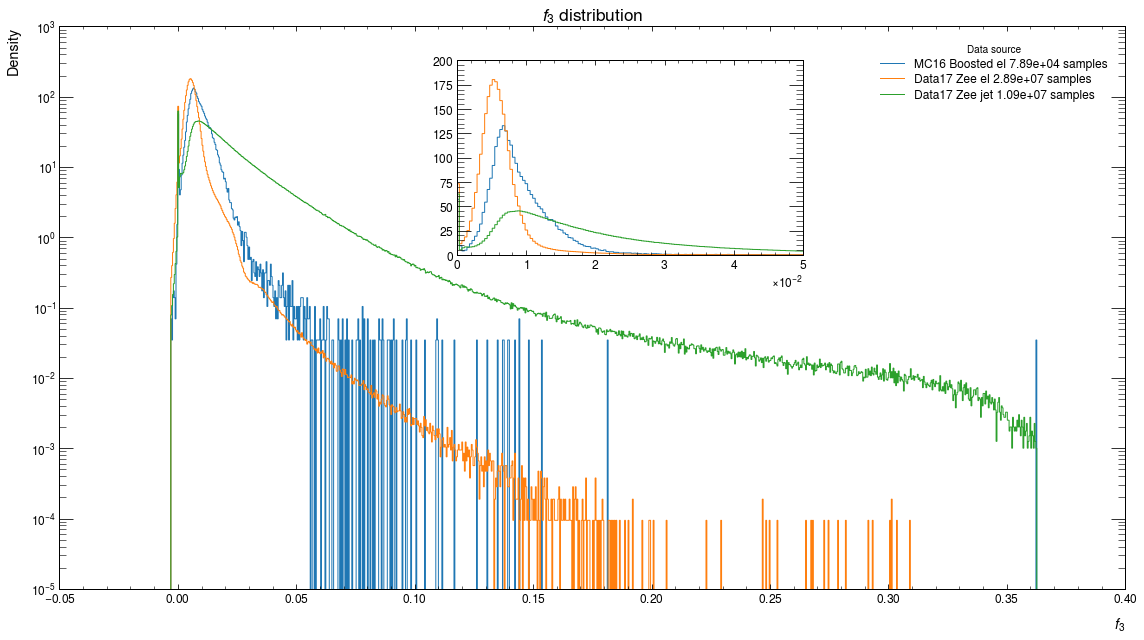

In [87]:
sub_ax_pos = [0.4, 0.6, 0.3, 0.3]
fig, ax = plt.subplots(1,1, figsize=(16,9), dpi=72)
plot_scale = 'log'
sub_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, org_hist_df in hists.items():
    n_samples = '{:.2e}'.format(int(org_hist_df['hist'].sum()))
    hist_df = normalize_hist(org_hist_df)
    label = f'{hist_name} {n_samples} samples'
    bins = np.append(hist_df['bin_start'].values, hist_df['bin_end'].iloc[-1])
    ax.stairs(hist_df['hist'],bins, label=label)
    sub_ax.stairs(hist_df['hist'],bins, label=label)

sub_ax.set_xlim(0,0.05)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_yscale(plot_scale)
# sub_ax.set_yscale(plot_scale)
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{plot_ss}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

In [89]:
save_hists_df(hists, output_dir, plot_ss)

0

### $\omega_{\eta 2}$
Radial variance of energy deposition in a 3x5 region of EM2 centered in the hottest cell.
Can have multiple values but two modes were identified with the free axis:
- [0, 0.06]: The distributions had different formats
- [98.999, 99]: There was a little number of samples and mostly all of them were 99. As a result of these factors the data between this interval was discarded.

In [113]:
hists = dict()
plot_ss = 'weta2'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss
# boosted_range = ss_info['range']
boosted_range = None
# boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_bins = 1000
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=boosted_bins, range=boosted_range)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)
# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_range = boosted_range
el_time = datetime.now()
print(f'Start electron time {el_time}')
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, range=el_range)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)
jet_time = datetime.now()
print(f'Electron hist time {jet_time-el_time}')
jet_bins = el_bins
jet_range = el_range
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, range=jet_range)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)
end_time = datetime.now()
print(f'Jet hist time {jet_time-el_time}')

Start electron time 2022-09-20 17:19:44.218878
Electron hist time 0:00:02.373708
Jet hist time 0:00:02.373708


In [ ]:
# sub_ax_pos = [0.1, 0.6, 0.3, 0.3]
fig, ax = plt.subplots(1,1, figsize=(16,9), dpi=72)
plot_scale = 'log'
# sub_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, org_hist_df in hists.items():
    n_samples = '{:.2e}'.format(int(org_hist_df['hist'].sum()))
    hist_df = normalize_hist(org_hist_df)
    label = f'{hist_name} {n_samples} samples'
    bins = np.append(hist_df['bin_start'].values, hist_df['bin_end'].iloc[-1])
    ax.stairs(hist_df['hist'],bins, label=label)
    # sub_ax.stairs(hist_df['hist'],bins, label=label)
# sub_ax.set_xlim(0.85,1)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_yscale(plot_scale)
# sub_ax.set_yscale(plot_scale)
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()
# fig.savefig(os.path.join(output_dir, f'{plot_ss}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

In [93]:
save_hists_df(hists, output_dir, plot_ss)

0

### $w_{stot}$

This shower shape is a root over a squared error, therefore, it cannot be negative. WHen building the histogram with a free range 3 modes were identified:
- -9999: Some samples had this value and were discarded
- [0, 468]: Showed excepted behavior

In [174]:
hists = dict()
plot_ss = 'wstot'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss
# boosted_range = ss_info['range']
boosted_range = (0,468)
# boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_bins = 10000
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=boosted_bins, range=boosted_range)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)
# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_range = boosted_range
el_time = datetime.now()
print(f'Start electron time {el_time}')
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, range=el_range)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)
jet_time = datetime.now()
print(f'Electron hist time {jet_time-el_time}')
jet_bins = el_bins
jet_range = el_range
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, range=jet_range)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)
end_time = datetime.now()
print(f'Jet hist time {jet_time-el_time}')

Start electron time 2022-09-20 18:07:08.640807
Electron hist time 0:00:02.136434
Jet hist time 0:00:02.136434


/tmp/ipykernel_1023/1724587799.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


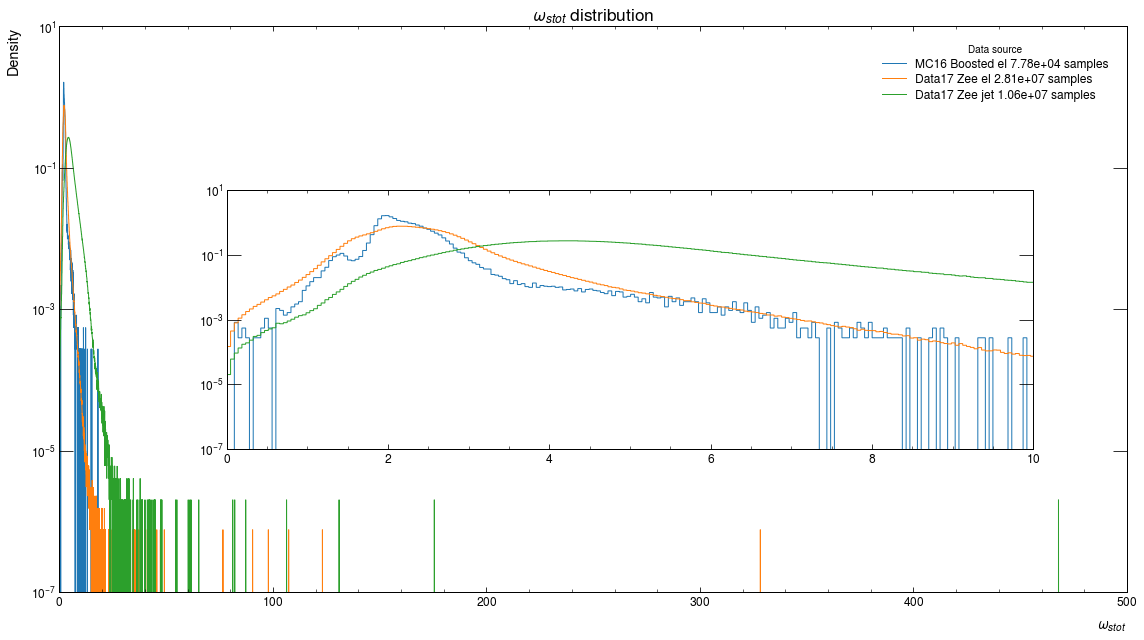

In [177]:
sub_ax_pos = [0.2, 0.3, 0.7, 0.4]
fig, ax = plt.subplots(1,1, figsize=(16,9), dpi=72)
plot_scale = 'log'
sub_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, org_hist_df in hists.items():
    n_samples = '{:.2e}'.format(int(org_hist_df['hist'].sum()))
    hist_df = normalize_hist(org_hist_df)
    label = f'{hist_name} {n_samples} samples'
    bins = np.append(hist_df['bin_start'].values, hist_df['bin_end'].iloc[-1])
    ax.stairs(hist_df['hist'],bins, label=label)
    sub_ax.stairs(hist_df['hist'],bins, label=label)
sub_ax.set_xlim(0,10)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_yscale(plot_scale)
sub_ax.set_yscale(plot_scale)
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{plot_ss}_limited_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

In [133]:
save_hists_df(hists, output_dir, plot_ss, name='first_interval')

0

### e2tsts1
For this shower shape there is a peak of negative values between [-999,0]. The name of the col starts with e which may indicate that this value is related to energy. Could not find on my articles what it means.

In [204]:
hists = dict()
plot_ss = 'e2tsts1'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss
# boosted_range = ss_info['range']
boosted_range = None
# boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_bins = 1000
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=boosted_bins, range=boosted_range)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)
# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_range = boosted_range
el_time = datetime.now()
print(f'Start electron time {el_time}')
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, range=el_range)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)
jet_time = datetime.now()
print(f'Electron hist time {jet_time-el_time}')
jet_bins = el_bins
jet_range = el_range
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, range=jet_range)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)
end_time = datetime.now()
print(f'Jet hist time {jet_time-el_time}')

Start electron time 2022-09-20 18:20:49.240852
Electron hist time 0:00:02.109255
Jet hist time 0:00:02.109255


/tmp/ipykernel_1023/4248349556.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


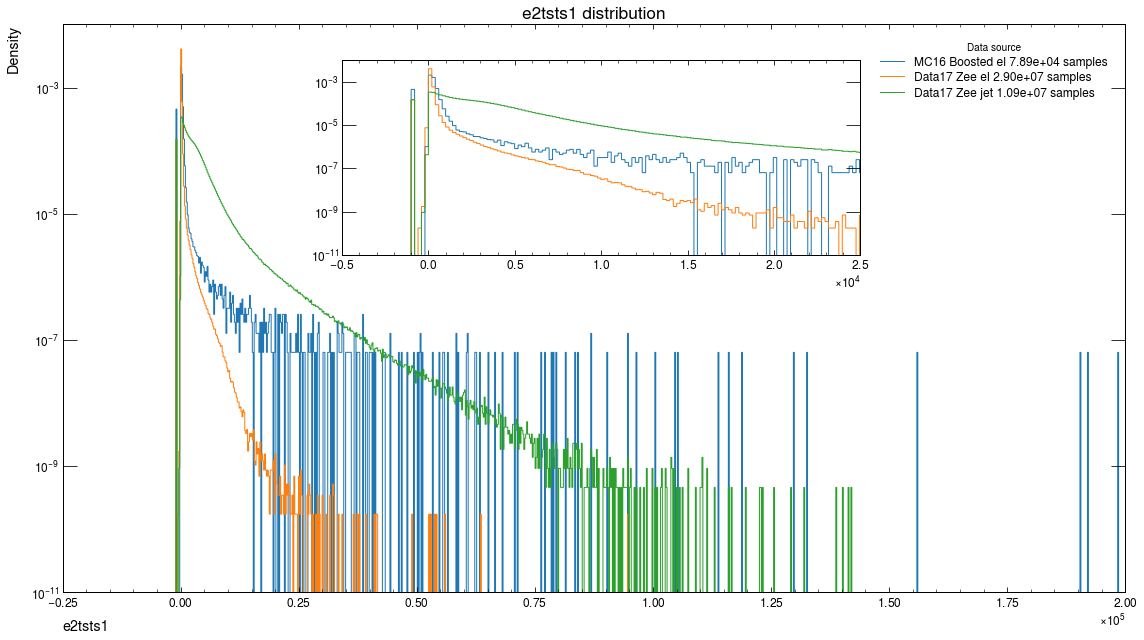

In [209]:
sub_ax_pos = [0.3, 0.6, 0.45, 0.3]
fig, ax = plt.subplots(1,1, figsize=(16,9), dpi=72)
plot_scale = 'log'
sub_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, org_hist_df in hists.items():
    n_samples = '{:.2e}'.format(int(org_hist_df['hist'].sum()))
    hist_df = normalize_hist(org_hist_df)
    label = f'{hist_name} {n_samples} samples'
    bins = np.append(hist_df['bin_start'].values, hist_df['bin_end'].iloc[-1])
    ax.stairs(hist_df['hist'],bins, label=label)
    sub_ax.stairs(hist_df['hist'],bins, label=label)
sub_ax.set_xlim(-0.05e5,0.25e5)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'], loc='left')
ax.legend(title='Data source')
ax.set_yscale(plot_scale)
sub_ax.set_yscale(plot_scale)
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{plot_ss}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

In [210]:
save_hists_df(hists, output_dir, plot_ss, 'free_range')

0

In [211]:
plt.close('all')